# Problem Statement

An education company named X Education sells online courses to industry professionals. 

X Education wants to select the most promising leads, i.e. the leads that are most likely to convert into paying customers. They wants to build a mdoel, wherein a leadscore is assigned to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

### Goals of the case study.

- Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.

- There are some more problems presented by the company which your model should be able to adjust to if the company's requirement changes in the future so you will need to handle these as well. These problems are provided in a separate doc file. Please fill it based on the logistic regression model you got in the first step. Also, make sure you include this in your final PPT where you'll make recommendations.

# 1. Importing Files and Reading dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [4]:
leads = pd.read_csv("Leads.csv")
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [5]:
leads.shape

(9240, 37)

In [6]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [7]:
# Check dataset balancing from target variable -
print("Dataset balance as per Target Variable:")
print("-"*20)
round((leads['Converted'].value_counts()/len(leads['Converted']))*100, 2)

Dataset balance as per Target Variable:
--------------------


0    61.46
1    38.54
Name: Converted, dtype: float64

# 2. EDA

## Handling NULL Values

### Converting Select to NaN

In [8]:
leads = leads.replace("Select", np.nan)

In [9]:
# Percentage of null values in the dataset

leads_null = leads.isna().mean().reset_index()
leads_null = leads_null.rename(columns = {"index": "Column Name", 0:"Missing Value"})
leads_null["Missing Value"] = leads_null["Missing Value"]*100
leads_null.sort_values(by = "Missing Value", ascending = False, inplace = True)

print("Null Values in the dataset", len(leads_null[leads_null['Missing Value'] > 0]))
leads_null[leads_null['Missing Value'] > 0]

Null Values in the dataset 17


,Column Name,Missing Value
13,How did you hear about X Education,78.463203
28,Lead Profile,74.188312
25,Lead Quality,51.590909
33,Asymmetrique Profile Score,45.649351
32,Asymmetrique Activity Score,45.649351
30,Asymmetrique Activity Index,45.649351
31,Asymmetrique Profile Index,45.649351
29,City,39.707792
12,Specialization,36.580087
24,Tags,36.287879


In [10]:
print("Non-Null Columns in the dataset:", len(leads_null[leads_null["Missing Value"] == 0]))
print("Columns with NULL values in the dataset:", len(leads_null[leads_null["Missing Value"] > 0]))
print("Columns with more than 45% NULL values in the dataset:", len(leads_null[leads_null["Missing Value"] > 45]))
print("Total Columns in the dataset:", len(leads_null))

Non-Null Columns in the dataset: 20
Columns with NULL values in the dataset: 17
Columns with more than 45% NULL values in the dataset: 7
Total Columns in the dataset: 37


In [11]:
# create a copy of dataset before dropping any columns for backup purpose
lead_df = leads.copy()

###### Creating a list of columns where NULL value % is greater than 45%. We will drop these columns and will not include these further in the analysis

In [12]:
lead_null_greaterthan45 = leads_null[leads_null["Missing Value"] >= 45]

lead_col_drop = list(lead_null_greaterthan45.iloc[:, 0])
lead_col_drop

['How did you hear about X Education',
 'Lead Profile',
 'Lead Quality',
 'Asymmetrique Profile Score',
 'Asymmetrique Activity Score',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index']

In [13]:
lead_df.drop(lead_col_drop, axis = 1, inplace = True)
lead_df.shape

(9240, 30)

### Check Unique values in all columns

In [14]:
lead_df_nunique = lead_df.nunique().reset_index()
lead_df_nunique = lead_df_nunique.rename(columns = {"index": "Column Name", 0:"Unique Values in col"})
lead_df_nunique.sort_values(by = "Unique Values in col", ascending = False, inplace = True)
lead_df_nunique

,Column Name,Unique Values in col
0,Prospect ID,9240
1,Lead Number,9240
8,Total Time Spent on Website,1731
9,Page Views Per Visit,114
7,TotalVisits,41
11,Country,38
23,Tags,26
3,Lead Source,21
12,Specialization,18
10,Last Activity,17


Columns which has same value across the entire data frame is of no use for modelling as they will not be able to uniquely qualify any entry. Hence we will remove all entries where `unique values in a column` is 1.

Similarly, Prospect ID and Lead Number both uniquely identifies each row in the dataset and hence we do not need 2 columns.

In [15]:
lead_single_val = lead_df_nunique[lead_df_nunique["Unique Values in col"] == 1]

lead_col_drop = list(lead_single_val.iloc[:, 0])
lead_col_drop.append("Prospect ID")
lead_col_drop

['Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'Magazine',
 'I agree to pay the amount through cheque',
 'Prospect ID']

In [16]:
lead_df.drop(lead_col_drop, axis = 1, inplace = True)
lead_df.shape

(9240, 24)

In [17]:
# Check data imbalance in each column
for col in lead_df.columns[1:]:
    print(col, ":")
    print(lead_df[col].value_counts(dropna=False, normalize=True))
    print("-"*30)
    print()

Lead Origin :
Landing Page Submission    0.528788
API                        0.387446
Lead Add Form              0.077706
Lead Import                0.005952
Quick Add Form             0.000108
Name: Lead Origin, dtype: float64
------------------------------

Lead Source :
Google               0.310390
Direct Traffic       0.275216
Olark Chat           0.189935
Organic Search       0.124892
Reference            0.057792
Welingak Website     0.015368
Referral Sites       0.013528
Facebook             0.005952
NaN                  0.003896
bing                 0.000649
google               0.000541
Click2call           0.000433
Press_Release        0.000216
Social Media         0.000216
Live Chat            0.000216
youtubechannel       0.000108
testone              0.000108
Pay per Click Ads    0.000108
welearnblog_Home     0.000108
WeLearn              0.000108
blog                 0.000108
NC_EDM               0.000108
Name: Lead Source, dtype: float64
------------------------------



In [18]:
# From Above query, we can create the list of columns where data imbalance is above 85% and we can remove those 
# columns from the dataset, as nothing conclusive can be drawn from that column

cols_high_imbalance = ['Do Not Email', 'Do Not Call', 'Country', 'What is your current occupation', 
                      'What matters most to you in choosing a course', 'Search', 'Newspaper Article', 'X Education Forums',
                      'Newspaper', 'Digital Advertisement', 'Through Recommendations']

We will remove `Do Not Email`, `Do Not Call`, `Search`, `Newspaper Article`, `X Education Forums`, `Newspaper`, `Digital Advertisement` and `Through Recommendations`  from the dataset, as there are 95%+ dataset skewed to  single category.  

We will remove `Country` as 70% data is India and 26% data is null which shows that almost 96% data is skewed.  

We will remove `What is your current occupation` as 60% data contains Unemployed and 29% data is null which shows that almost 89% data is skewed.  

We will remove `What matters most to you in choosing a course` as 70% data contains Better Career Prospects and 29% data is null which shows that almost 99% data is skewed.  

In [19]:
lead_df.drop(cols_high_imbalance, axis = 1, inplace = True)
lead_df.shape

(9240, 13)

In [20]:
lead_df.columns

Index(['Lead Number', 'Lead Origin', 'Lead Source', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Specialization', 'Tags', 'City',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [21]:
# Percentage of null values in the dataset

leads_null = lead_df.isna().mean().reset_index()
leads_null = leads_null.rename(columns = {"index": "Column Name", 0:"Missing Value"})
leads_null["Missing Value"] = leads_null["Missing Value"]*100
leads_null.sort_values(by = "Missing Value", ascending = False, inplace = True)

print("Null Values in the dataset", len(leads_null[leads_null['Missing Value'] > 0]))
leads_null[leads_null['Missing Value'] > 0]

Null Values in the dataset 7


,Column Name,Missing Value
10,City,39.707792
8,Specialization,36.580087
9,Tags,36.287879
4,TotalVisits,1.482684
6,Page Views Per Visit,1.482684
7,Last Activity,1.114719
2,Lead Source,0.389610


In [22]:
print("Non-Null Columns in the dataset:", len(leads_null[leads_null["Missing Value"] == 0]))
print("Columns with NULL values in the dataset:", len(leads_null[leads_null["Missing Value"] > 0]))
print("Columns with more than 45% NULL values in the dataset:", len(leads_null[leads_null["Missing Value"] > 45]))
print("Total Columns in the dataset:", len(leads_null))

Non-Null Columns in the dataset: 6
Columns with NULL values in the dataset: 7
Columns with more than 45% NULL values in the dataset: 0
Total Columns in the dataset: 13


In [23]:
# checking the values in these columns where null value is available

cols = leads_null[leads_null['Missing Value'] > 0].copy()

for col in cols['Column Name']:
    print(col, ":")
    print(lead_df[col].value_counts(dropna=False))
    print("-"*30)
    print()

City :
NaN                            3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64
------------------------------

Specialization :
NaN                                  3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                    

In [24]:
# check columns with null values < 2%
lead_null_lessthan2 = leads_null[(leads_null["Missing Value"] < 2) & (leads_null["Missing Value"] > 0)]

lead_col = list(lead_null_lessthan2.iloc[:, 0])
lead_col

['TotalVisits', 'Page Views Per Visit', 'Last Activity', 'Lead Source']

In [25]:
# We will drop those rows where null values are less than 2% as it will not be any significant impact our analysis

lead_df.dropna(subset=lead_col, inplace = True)
lead_df.shape

(9074, 13)

#### Specialization

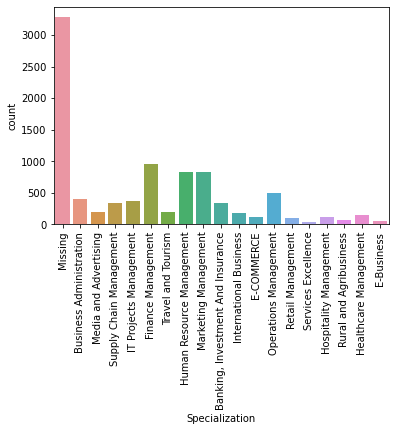

In [26]:
sns.countplot(lead_df['Specialization'].fillna('Missing'))
plt.xticks(rotation = 90)
plt.show()

In [27]:
# It can be clearly noticed that null values in specialization are not linked to any other value, 
# hence we will impute "Others" in the field

lead_df['Specialization'] = lead_df['Specialization'].replace(np.nan, 'Others')

In [29]:
# Percentage of null values in the dataset

leads_null = lead_df.isna().mean().reset_index()
leads_null = leads_null.rename(columns = {"index": "Column Name", 0:"Missing Value"})
leads_null["Missing Value"] = leads_null["Missing Value"]*100
leads_null.sort_values(by = "Missing Value", ascending = False, inplace = True)

print("Null Values in the dataset", len(leads_null[leads_null['Missing Value'] > 0]))
leads_null[leads_null['Missing Value'] > 0]

Null Values in the dataset 2


,Column Name,Missing Value
10,City,39.398281
9,Tags,36.665197


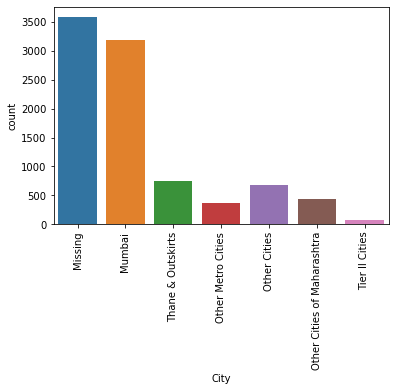

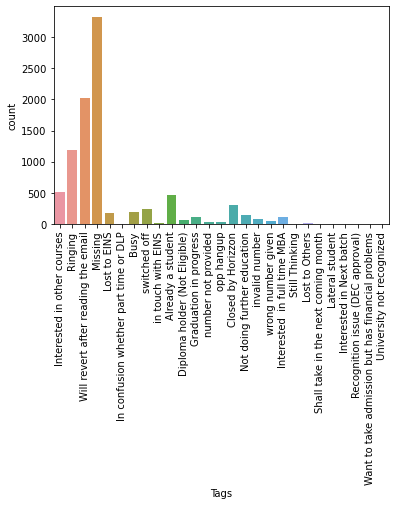

In [30]:
remain_col = leads_null[leads_null['Missing Value'] > 0].copy()

for col in remain_col['Column Name']: 
    sns.countplot(lead_df[col].fillna('Missing'))
    plt.xticks(rotation = 90)
    plt.show()

In [31]:
# For the remaining columns, we can impute the mode value in null values in the respective columns as 
# these are generalized terms and can be imputed in the chart

for col in remain_col['Column Name']:
    lead_df[col].fillna(lead_df[col].mode().values[0], inplace=True)

In [32]:
# Percentage of null values in the dataset

leads_null = lead_df.isna().mean().reset_index()
leads_null = leads_null.rename(columns = {"index": "Column Name", 0:"Missing Value"})
leads_null["Missing Value"] = leads_null["Missing Value"]*100
leads_null.sort_values(by = "Missing Value", ascending = False, inplace = True)

print("Non-Null Columns in the dataset:", len(leads_null[leads_null["Missing Value"] == 0]))
print("Columns with NULL values in the dataset:", len(leads_null[leads_null["Missing Value"] > 0]))
print("Total Columns in the dataset:", len(leads_null))

Non-Null Columns in the dataset: 13
Columns with NULL values in the dataset: 0
Total Columns in the dataset: 13


##### Below is the final column list from the dataset with no null values in any column

In [33]:
lead_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9074 entries, 0 to 9239
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Number                             9074 non-null   int64  
 1   Lead Origin                             9074 non-null   object 
 2   Lead Source                             9074 non-null   object 
 3   Converted                               9074 non-null   int64  
 4   TotalVisits                             9074 non-null   float64
 5   Total Time Spent on Website             9074 non-null   int64  
 6   Page Views Per Visit                    9074 non-null   float64
 7   Last Activity                           9074 non-null   object 
 8   Specialization                          9074 non-null   object 
 9   Tags                                    9074 non-null   object 
 10  City                                    9074 non-null   obje

## Univariate/ Bivariate Analysis

In [42]:
# Check data balance in finalized category column list

cat_col_list = lead_df.select_dtypes(include=['object']).columns

for col in cat_col_list:
    print(col, ":")
    print(lead_df[col].value_counts(dropna=False, normalize=True))
    print("-"*30)
    print()

Lead Origin :
Landing Page Submission    0.538351
API                        0.394313
Lead Add Form              0.064029
Lead Import                0.003306
Name: Lead Origin, dtype: float64
------------------------------

Lead Source :
Google               0.316068
Direct Traffic       0.280251
Olark Chat           0.193189
Organic Search       0.127177
Reference            0.048821
Welingak Website     0.014216
Referral Sites       0.013776
Facebook             0.003416
bing                 0.000661
google               0.000551
Click2call           0.000441
Press_Release        0.000220
Social Media         0.000220
Live Chat            0.000220
youtubechannel       0.000110
testone              0.000110
Pay per Click Ads    0.000110
welearnblog_Home     0.000110
WeLearn              0.000110
blog                 0.000110
NC_EDM               0.000110
Name: Lead Source, dtype: float64
------------------------------

Last Activity :
Email Opened                    0.378223
SMS Sent 

In [43]:
# Standardizing and Combining categories which have very less data values 

# Lead Origin
lead_df['Lead Origin'] = lead_df['Lead Origin'].replace(['Lead Add Form','Lead Import'] ,'Lead Add Form and Import') 


# Lead Source
lead_df['Lead Source'] = lead_df['Lead Source'].replace('google','Google')
lead_df['Lead Source'] = lead_df['Lead Source'].replace('Facebook','Social Media')
lead_df['Lead Source'] = lead_df['Lead Source'].replace(['bing','Click2call','Press_Release',
                                                     'youtubechannel','welearnblog_Home',
                                                     'WeLearn','blog','Pay per Click Ads',
                                                    'testone','NC_EDM'] ,'Others') 

# Last Activity
lead_df['Last Activity'] = lead_df['Last Activity'].replace(['Unreachable','Unsubscribed', 'Had a Phone Conversation', 
                                                        'Approached upfront', 'View in browser link Clicked',       
                                                        'Email Marked Spam',  'Email Received','Resubscribed to emails',
                                                         'Visited Booth in Tradeshow'],'Others')

# Last Notable Activity
lead_df['Last Notable Activity'] = lead_df['Last Notable Activity'].replace(['Had a Phone Conversation',
                                                                       'Email Marked Spam', 'Unreachable', 'Unsubscribed', 
                                                                        'Email Bounced', 'Resubscribed to emails',
                                                                       'View in browser link Clicked',
                                                                       'Approached upfront', 'Form Submitted on Website', 
                                                                       'Email Received'],'Other_Notable_activity')

# Tags
lead_df['Tags'] = lead_df['Tags'].replace(['invalid number', 'Diploma holder (Not Eligible)', 'wrong number given',
                                           'opp hangup', 'number not provided', 'in touch with EINS', 'Lost to Others',
                                           'Want to take admission but has financial problems', 'Still Thinking',
                                           'Interested in Next batch', 'In confusion whether part time or DLP',
                                           'Lateral student', 'Shall take in the next coming month', 
                                           'University not recognized', 'Recognition issue (DEC approval)'], 'Others')



In [44]:
# Check data balance in finalized category column list

cat_col_list = lead_df.select_dtypes(include=['object']).columns

for col in cat_col_list:
    print(col, ":")
    print(lead_df[col].value_counts(dropna=False, normalize=True))
    print("-"*30)
    print()

Lead Origin :
Landing Page Submission     0.538351
API                         0.394313
Lead Add Form and Import    0.067335
Name: Lead Origin, dtype: float64
------------------------------

Lead Source :
Google              0.316619
Direct Traffic      0.280251
Olark Chat          0.193189
Organic Search      0.127177
Reference           0.048821
Welingak Website    0.014216
Referral Sites      0.013776
Social Media        0.003637
Others              0.002094
Live Chat           0.000220
Name: Lead Source, dtype: float64
------------------------------

Last Activity :
Email Opened                 0.378223
SMS Sent                     0.299317
Olark Chat Conversation      0.107119
Page Visited on Website      0.070531
Converted to Lead            0.047168
Email Bounced                0.034384
Email Link Clicked           0.029425
Others                       0.021049
Form Submitted on Website    0.012784
Name: Last Activity, dtype: float64
------------------------------

Specializatio

In [45]:
# Standardizing and Combining categories which have very less data values 

# Lead Source
lead_df['Lead Source'] = lead_df['Lead Source'].replace(['Reference', 'Welingak Website', 'Referral Sites', 'Social Media',
                                                         'Others', 'Live Chat'] ,'Others') 

# Last Activity
lead_df['Last Activity'] = lead_df['Last Activity'].replace(['Email Link Clicked', 'Others', 'Form Submitted on Website'],
                                                            'Others')

# Tags
lead_df['Tags'] = lead_df['Tags'].replace(['Already a student', 'Graduation in progress'], 'Student')
lead_df['Tags'] = lead_df['Tags'].replace(['Interested in other courses', 'Interested  in full time MBA'], 
                                          'Interested in other courses')
lead_df['Tags'] = lead_df['Tags'].replace(['switched off', 'Busy'], 'Switched Off/ Busy')
lead_df['Tags'] = lead_df['Tags'].replace(['Closed by Horizzon', 'Others', 'Lost to EINS', 'Not doing further education'], 
                                          'Others')

# Last Notable Activity
lead_df['Last Notable Activity'] = lead_df['Last Notable Activity'].replace(['Page Visited on Website', 
                                                                             'Olark Chat Conversation', 
                                                                             'Email Link Clicked', 
                                                                             'Other_Notable_activity' ],
                                                                            'Other_Notable_activity')


In [46]:
# Check data balance in finalized category column list

cat_col_list = lead_df.select_dtypes(include=['object']).columns

for col in cat_col_list:
    print(col, ":")
    print(lead_df[col].value_counts(dropna=False, normalize=True))
    print("-"*30)
    print()

Lead Origin :
Landing Page Submission     0.538351
API                         0.394313
Lead Add Form and Import    0.067335
Name: Lead Origin, dtype: float64
------------------------------

Lead Source :
Google            0.316619
Direct Traffic    0.280251
Olark Chat        0.193189
Organic Search    0.127177
Others            0.082764
Name: Lead Source, dtype: float64
------------------------------

Last Activity :
Email Opened               0.378223
SMS Sent                   0.299317
Olark Chat Conversation    0.107119
Page Visited on Website    0.070531
Others                     0.063258
Converted to Lead          0.047168
Email Bounced              0.034384
Name: Last Activity, dtype: float64
------------------------------

Specialization :
Others                               0.361693
Finance Management                   0.105687
Human Resource Management            0.092242
Marketing Management                 0.090699
Operations Management                0.054992
Business Ad

In [47]:
# We will bifurcate the field list in different sets to easily analyze teh column values
set_1 = ['City', 'Specialization', 'Lead Source', 'Lead Origin', 'Last Activity', 'Last Notable Activity'] 
set_2 = ['Tags', 'A free copy of Mastering The Interview']
set_3 = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

### Analysis of set_1

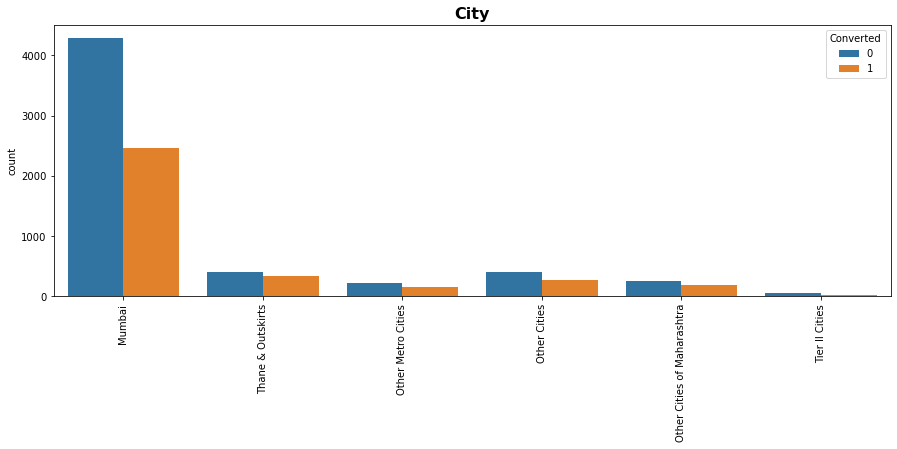

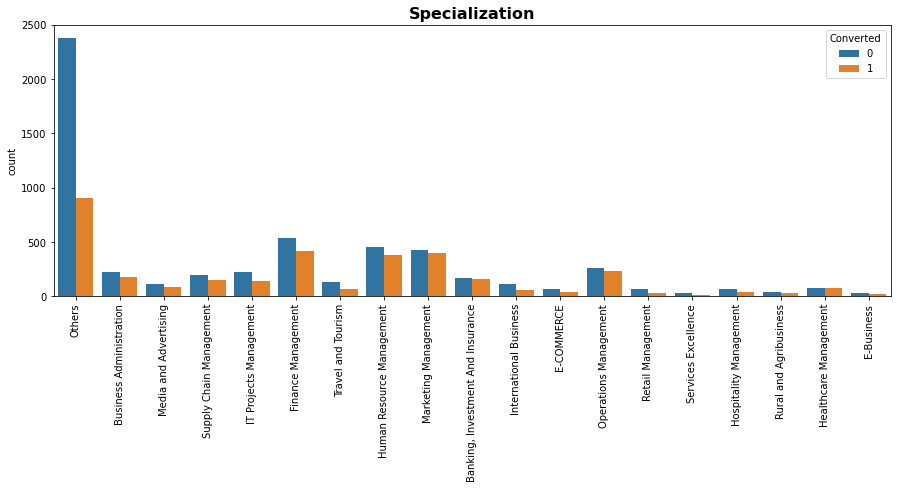

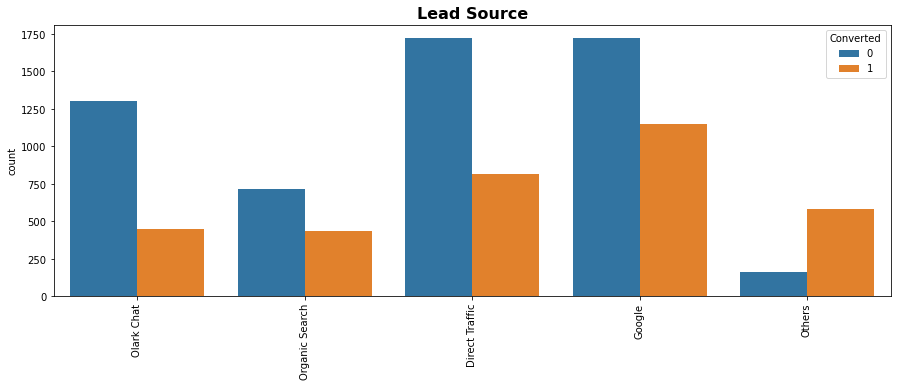

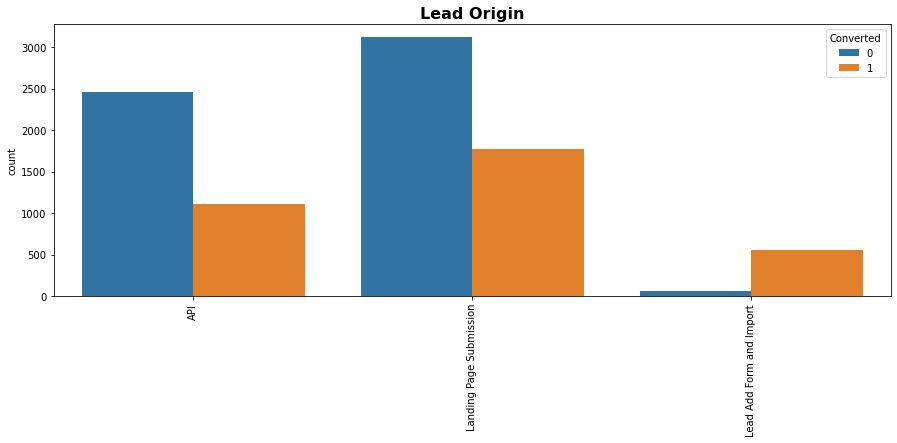

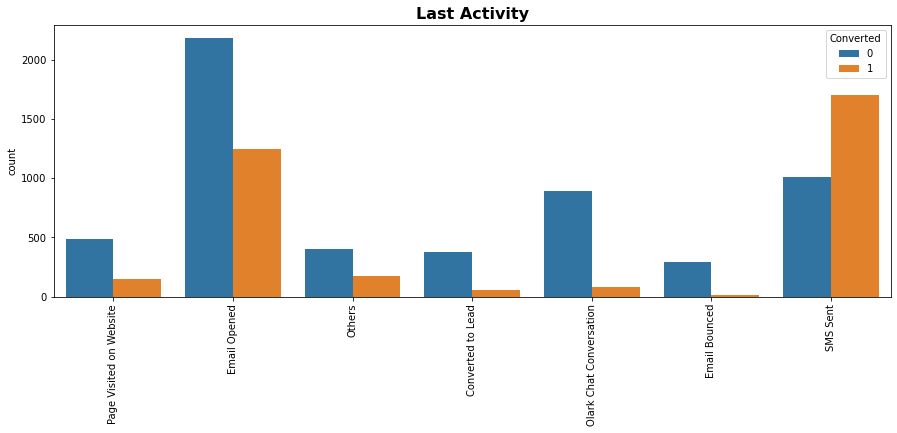

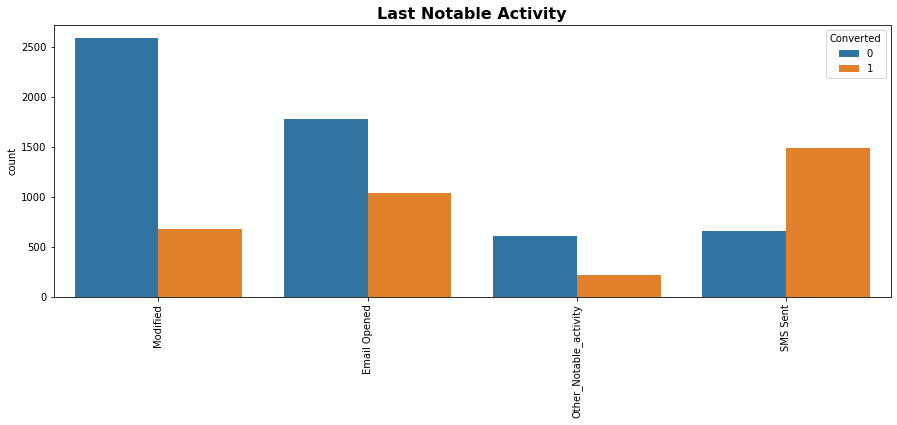

In [48]:
for i in set_1:
    
    plt.figure(figsize=(15, 5))
    sns.countplot(lead_df[i], hue=lead_df['Converted'])
    plt.xticks(rotation = 90)
    plt.title(i, fontsize=16, fontweight = "bold")
    plt.xlabel(xlabel = "")
    plt.show()

##### Observations -
- `City` - Maximum leads are from Mumbai region. We can use this column to draw insights
- `Specialization` - We can use this column to draw some insights
- `Lead Source` - Maximum leads are from Direct Traffic or Google. We can use this column to draw insights
- `Lead Origin` - 
    - Highest number of leads as well as conversions can be seen from API and Landing Page Submission
    - Lead Add Form and Import gives a very high conversion rate but count of leads are not very high
- `Last Activity` - 
    - From SMS Sent category conversion rate is very high
    - Max leads are generated from Email
- `Last Notable Activity` - 
    - From SMS Sent category conversion rate is very high
    - Max leads are generated from Modified and Email category

### Analysis of set_2

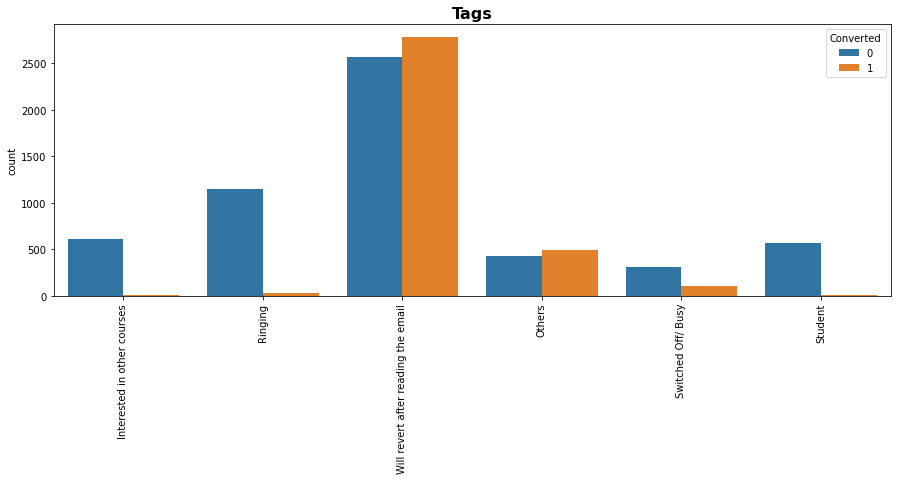

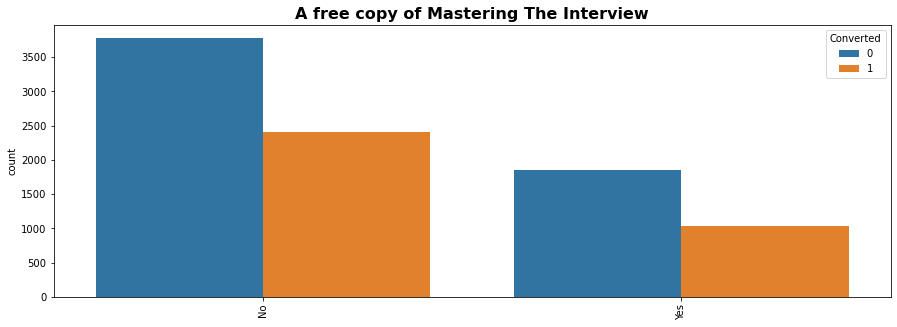

In [50]:
for i in set_2:
    plt.figure(figsize=(15, 5))
    sns.countplot(lead_df[i], hue=lead_df['Converted'])
    plt.xticks(rotation = 90)
    plt.title(i, fontsize=16, fontweight = "bold")
    plt.xlabel(xlabel = "")
    plt.show()

##### Observations -
- `Tags` - Max leads and conversions are happening from email category. Same was noted in set_1 data fields  
- `A free copy of Mastering The Interview` -This can be used in the modeling to check if this feature has any impact on conversion 

### Analysis of set_3

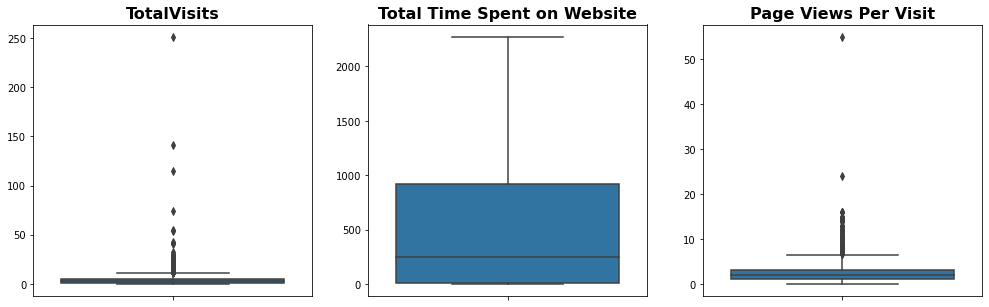

In [52]:
j = 0
plt.subplots(1, 3, figsize=(17, 5))
for i in set_3:
    j += 1
    plt.subplot(1, 3, j)
    sns.boxplot(y = lead_df[i], hue=lead_df['Converted'])
    plt.xticks(rotation = 90)
    plt.title(i, fontsize=16, fontweight = "bold")
    plt.ylabel(ylabel = "")
plt.show()

##### Observations -
- `TotalVisits` - There are outliers in the field and hence we can check after removing the outliers
- `Total Time Spent on Website` - No outliers present in the column and hence this can be used as is in modeling
- `Page Views Per Visit` - There are outliers in the field and hence we can check after removing the outliers

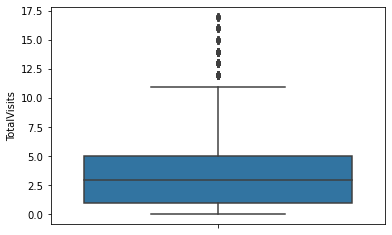

In [53]:
# TotalVisits - Outlier Treatment - Remove top & bottom 1% of the Column Outlier values

Q3 = lead_df.TotalVisits.quantile(0.99)
lead_df = lead_df[(lead_df.TotalVisits <= Q3)]
Q1 = lead_df.TotalVisits.quantile(0.01)
lead_df = lead_df[(lead_df.TotalVisits >= Q1)]
sns.boxplot(y=lead_df['TotalVisits'])
plt.show()

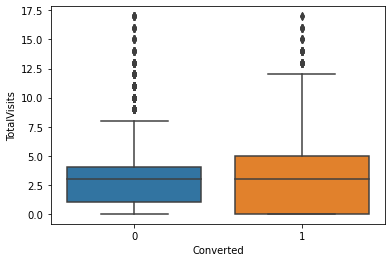

In [54]:
sns.boxplot(y = 'TotalVisits', x = 'Converted', data = lead_df)
plt.show()

- Median for converted and non-converted leads are same

In [55]:
lead_df.shape

(8991, 13)

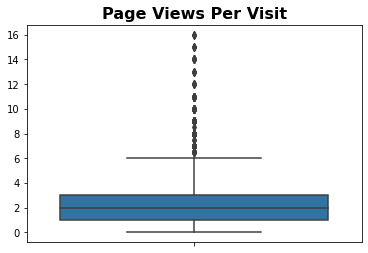

In [56]:
# Check Page Views Per Visit field after outlier treatment for Totalvisits column

sns.boxplot(y = lead_df['Page Views Per Visit'], hue=lead_df['Converted'])
plt.xticks(rotation = 90)
plt.title('Page Views Per Visit', fontsize=16, fontweight = "bold")
plt.ylabel(ylabel = "")
plt.show()

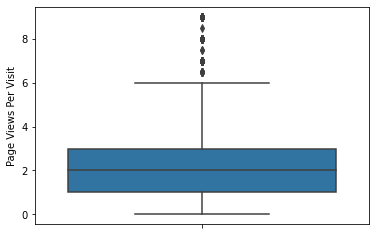

In [57]:
# Page Views Per Visit - Outlier Treatment - Remove top & bottom 1% of the Column Outlier values

Q3 = lead_df['Page Views Per Visit'].quantile(0.99)
lead_df = lead_df[(lead_df['Page Views Per Visit'] <= Q3)]
Q1 = lead_df['Page Views Per Visit'].quantile(0.01)
lead_df = lead_df[(lead_df['Page Views Per Visit'] >= Q1)]
sns.boxplot(y=lead_df['Page Views Per Visit'])
plt.show()

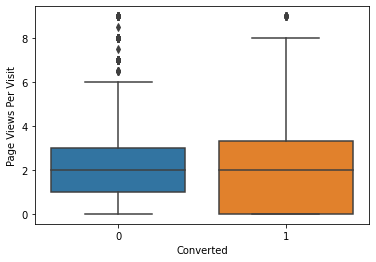

In [58]:
sns.boxplot(y = 'Page Views Per Visit', x = 'Converted', data = lead_df)
plt.show()

- Median for converted and non-converted leads are same

In [59]:
lead_df.shape

(8924, 13)

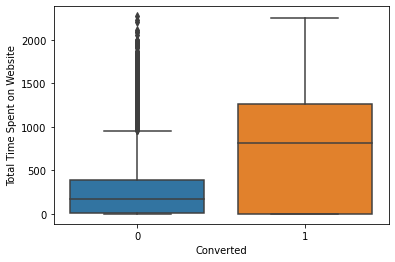

In [60]:
# coparison for Total Time Spent on Website with target variable
sns.boxplot(y = 'Total Time Spent on Website', x = 'Converted', data = lead_df)
plt.show()

- Leads spending more time on website have high conversion rate probability

In [64]:
print("Final Dataset ROWS retained post null value handling and univariate/bivariate analysis is :")
print("-"*90)
round((lead_df.shape[0]/leads.shape[0])*100, 2)

Final Dataset ROWS retained post null value handling and univariate/bivariate analysis is :
------------------------------------------------------------------------------------------


96.58

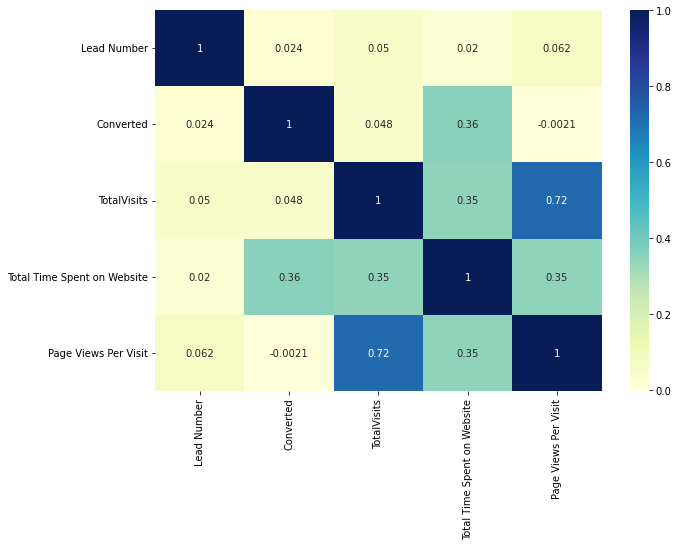

In [65]:
plt.figure(figsize=(10,7))
sns.heatmap(lead_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

# Data Preparation for Modeling

## Dummy Variable Creation

In [66]:
lead_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8924 entries, 0 to 9239
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Number                             8924 non-null   int64  
 1   Lead Origin                             8924 non-null   object 
 2   Lead Source                             8924 non-null   object 
 3   Converted                               8924 non-null   int64  
 4   TotalVisits                             8924 non-null   float64
 5   Total Time Spent on Website             8924 non-null   int64  
 6   Page Views Per Visit                    8924 non-null   float64
 7   Last Activity                           8924 non-null   object 
 8   Specialization                          8924 non-null   object 
 9   Tags                                    8924 non-null   object 
 10  City                                    8924 non-null   obje

In [67]:
category_cols= lead_df.select_dtypes(include=['object']).columns

for col in category_cols:
    print("-------", col, "-------")
    print(lead_df[col].value_counts())
    print("-"*40)

------- Lead Origin -------
Landing Page Submission     4768
API                         3546
Lead Add Form and Import     610
Name: Lead Origin, dtype: int64
----------------------------------------
------- Lead Source -------
Google            2841
Direct Traffic    2499
Olark Chat        1751
Organic Search    1092
Others             741
Name: Lead Source, dtype: int64
----------------------------------------
------- Last Activity -------
Email Opened               3385
SMS Sent                   2678
Olark Chat Conversation     966
Page Visited on Website     594
Others                      563
Converted to Lead           428
Email Bounced               310
Name: Last Activity, dtype: int64
----------------------------------------
------- Specialization -------
Others                               3262
Finance Management                    942
Human Resource Management             819
Marketing Management                  814
Operations Management                 494
Business Admin

In [68]:
# Converting Binary Variables (Yes/No) to 1/0

varlist =  ['A free copy of Mastering The Interview']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the list
lead_df[varlist] = lead_df[varlist].apply(binary_map)

lead_df.head()

,Lead Number,Lead Origin,Lead Source,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,Tags,City,A free copy of Mastering The Interview,Last Notable Activity
0,660737,API,Olark Chat,0,0.0,0,0.0,Page Visited on Website,Others,Interested in other courses,Mumbai,0,Modified
1,660728,API,Organic Search,0,5.0,674,2.5,Email Opened,Others,Ringing,Mumbai,0,Email Opened
2,660727,Landing Page Submission,Direct Traffic,1,2.0,1532,2.0,Email Opened,Business Administration,Will revert after reading the email,Mumbai,1,Email Opened
3,660719,Landing Page Submission,Direct Traffic,0,1.0,305,1.0,Others,Media and Advertising,Ringing,Mumbai,0,Modified
4,660681,Landing Page Submission,Google,1,2.0,1428,1.0,Converted to Lead,Others,Will revert after reading the email,Mumbai,0,Modified


In [70]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy = pd.get_dummies(lead_df['Lead Origin'], prefix  = 'Origin', drop_first=True)
lead_df = pd.concat([lead_df, dummy], axis = 1)

dummy = pd.get_dummies(lead_df['Lead Source'], prefix  = 'Source')
dummy = dummy.drop(['Source_Others'], 1)
lead_df = pd.concat([lead_df, dummy], axis = 1)

dummy = pd.get_dummies(lead_df['Last Activity'], prefix  = 'Activity')
dummy = dummy.drop(['Activity_Others'], 1)
lead_df = pd.concat([lead_df, dummy], axis = 1)

dummy = pd.get_dummies(lead_df['Specialization'], prefix  = 'Specialization')
dummy = dummy.drop(['Specialization_Others'], 1)
lead_df = pd.concat([lead_df, dummy], axis = 1)

dummy = pd.get_dummies(lead_df['Tags'], prefix  = 'Tags')
dummy = dummy.drop(['Tags_Others'], 1)
lead_df = pd.concat([lead_df, dummy], axis = 1)

dummy = pd.get_dummies(lead_df['City'], prefix  = 'City')
dummy = dummy.drop(['City_Other Cities'], 1)
lead_df = pd.concat([lead_df, dummy], axis = 1)

dummy = pd.get_dummies(lead_df['Last Notable Activity'], prefix  = 'Last Notable Activity')
dummy = dummy.drop(['Last Notable Activity_Other_Notable_activity'], 1)
lead_df = pd.concat([lead_df, dummy], axis = 1)

In [71]:
# After creating dummy variables, dropping original columns

lead_df.drop(['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization', 'Tags', 'City', 
              'Last Notable Activity'], axis = 1, inplace = True)

lead_df.columns

Index(['Lead Number', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit',
       'A free copy of Mastering The Interview',
       'Origin_Landing Page Submission', 'Origin_Lead Add Form and Import',
       'Source_Direct Traffic', 'Source_Google', 'Source_Olark Chat',
       'Source_Organic Search', 'Activity_Converted to Lead',
       'Activity_Email Bounced', 'Activity_Email Opened',
       'Activity_Olark Chat Conversation', 'Activity_Page Visited on Website',
       'Activity_SMS Sent', 'Specialization_Banking, Investment And Insurance',
       'Specialization_Business Administration', 'Specialization_E-Business',
       'Specialization_E-COMMERCE', 'Specialization_Finance Management',
       'Specialization_Healthcare Management',
       'Specialization_Hospitality Management',
       'Specialization_Human Resource Management',
       'Specialization_IT Projects Management',
       'Specialization_International Business',
       'Specializatio

In [72]:
lead_df.shape

(8924, 49)

## Train Test Split

In [87]:
# Putting feature variable to X
X = lead_df.drop(['Lead Number','Converted'], axis=1)

# Putting response variable to y
y = lead_df['Converted']

y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [88]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

## Feature Scaling

In [90]:
scaler = StandardScaler()

numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

X_train.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Origin_Landing Page Submission,Origin_Lead Add Form,Origin_Lead Import,Source_Direct Traffic,Source_Google,Source_Live Chat,Source_Olark Chat,Source_Organic Search,Source_Reference,Source_Referral Sites,Source_Social Media,Source_Welingak Website,Activity_Converted to Lead,Activity_Email Bounced,Activity_Email Link Clicked,Activity_Email Opened,Activity_Form Submitted on Website,Activity_Olark Chat Conversation,Activity_Page Visited on Website,Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Occupation_Housewife,Occupation_Other,Occupation_Student,Occupation_Unemployed,Occupation_Working Professional,Tags_Already a student,Tags_Busy,Tags_Closed by Horizzon,Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Ringing,Tags_Will revert after reading the email,Tags_switched off,City_Mumbai,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent
6676,-0.285584,-0.049636,1.395668,0.395289,-0.669212,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
6138,-0.285584,0.297929,0.609686,0.926758,-0.669212,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
8650,-0.285584,-0.049636,1.178657,0.395289,1.494296,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
3423,-0.285584,-1.092332,-0.878390,-1.199117,-0.669212,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
6552,-0.285584,-1.092332,-0.878390,-1.199117,-0.669212,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0


In [92]:
### Checking the Conversion Rate
conversion_rate = (sum(lead_df['Converted'])/len(lead_df['Converted'].index))*100
conversion_rate

37.75212909009413

## Correlation in features

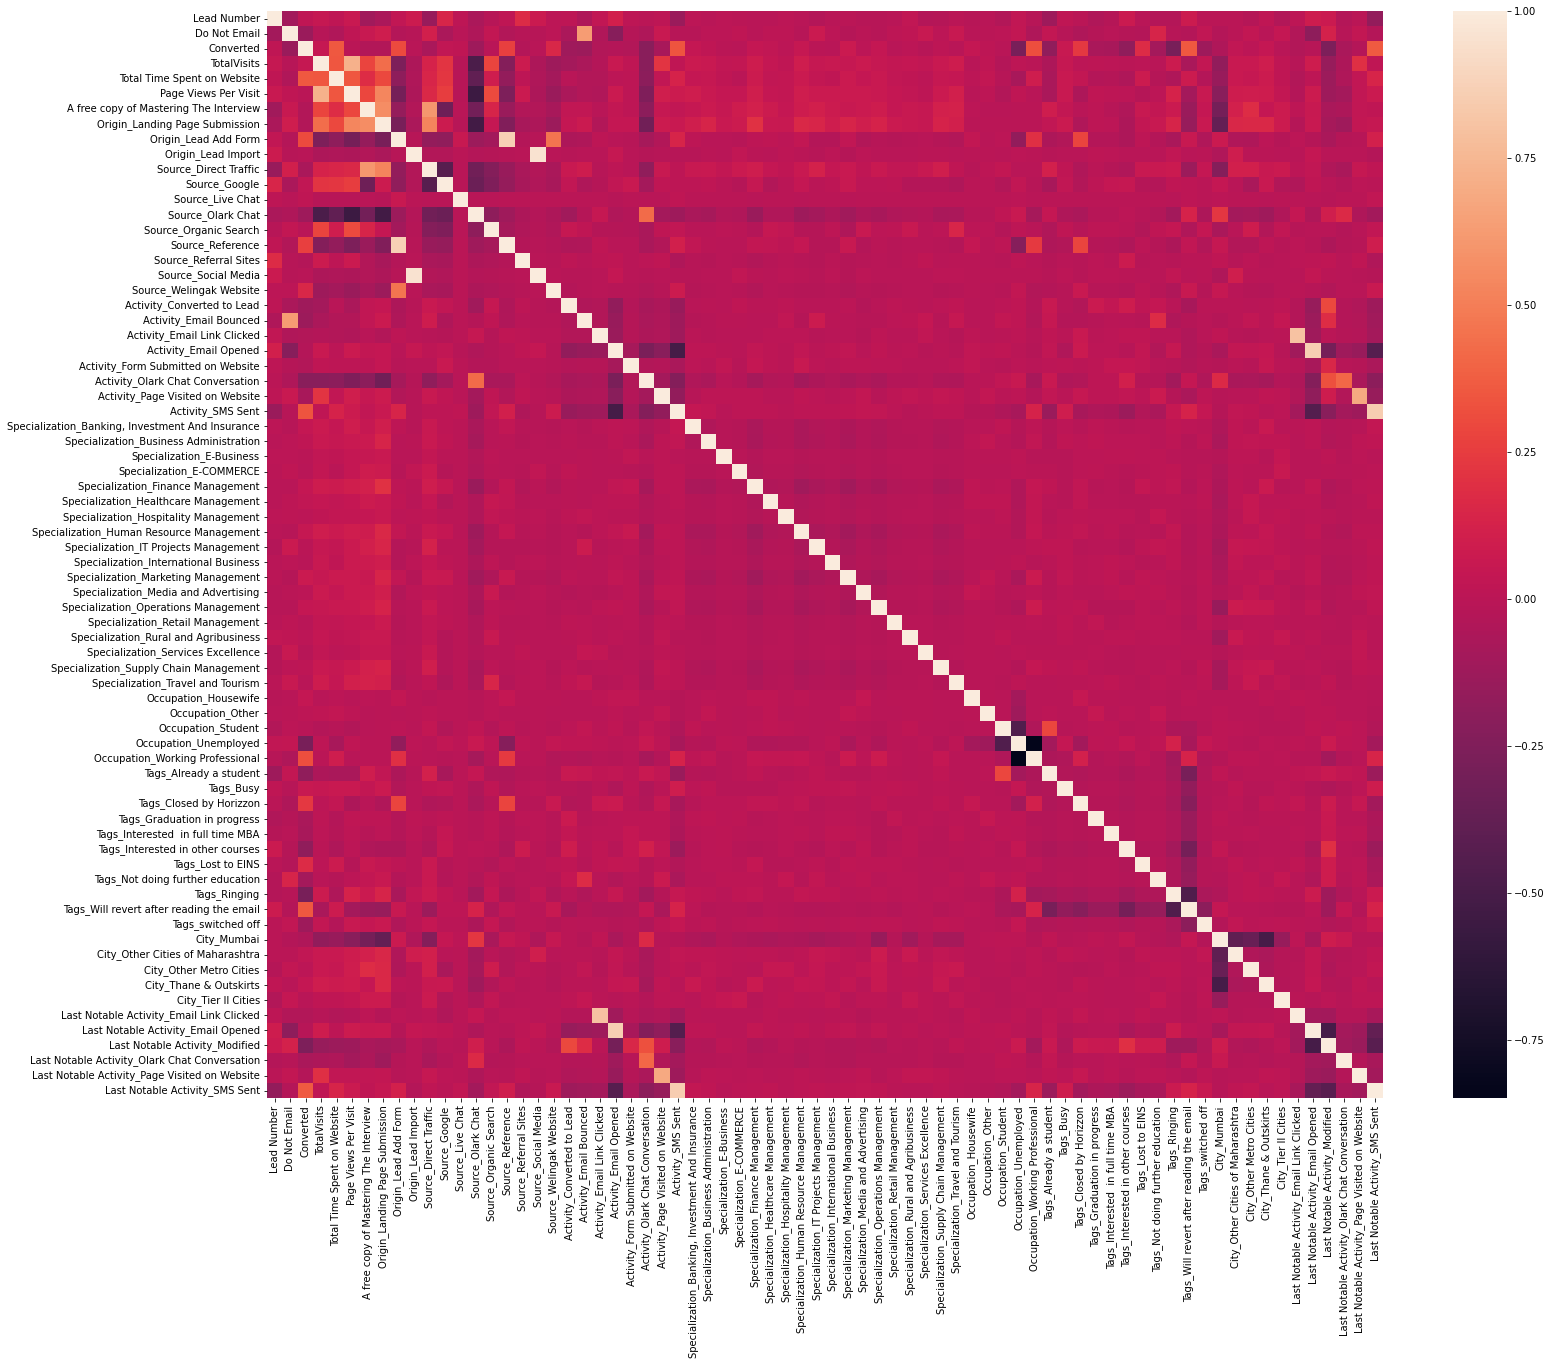

In [95]:
# Let's see the correlation matrix 
plt.figure(figsize = (25,20))        # Size of the figure
sns.heatmap(lead_df.corr())
plt.show()